### Edgar Moises Hernandez-Gonzalez
#### 16/05/20-17/07/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFT (3D)
##### Entrada de 990x31
##### Validacion cruzada

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-ID-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-ID-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/Etiquetas-ID-A09T.csv", header=None).values
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/Etiquetas-ID-A09E.csv", header=None).values

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 22000)
(144, 22000)
(144, 1)
(144, 1)


In [7]:
x = pd.concat([x_train, x_test])
y = np.concatenate((y_train, y_test))

In [8]:
print(x.shape)
print(y.shape)

(288, 22000)
(288, 1)


In [9]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 288


In [10]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [11]:
# las etiquetas en categorical para poder entrenar data augmentation
# y_categorical = to_categorical(y)

In [12]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((data.shape[0],990,31))
  temporal = np.zeros((990,31))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=250, window='hann', nperseg=250,
                              noverlap=225, nfft=500, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
#llamar a unir_espectrogramas_vertical(data)
inicio = time.time()

x = unir_espectrogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
Tiempo: 5.276137113571167


In [14]:
print(x.shape)

(288, 990, 31)


In [15]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

346.64816258171294
4.446238817713953e-08
1.6562540557634025


In [16]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [17]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.99898607
1.2813368e-10
0.0047730696


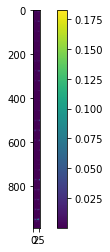

In [18]:
plt.figure()
plt.imshow(x[2])
plt.colorbar()
plt.show()

In [19]:
#convertir de 3D a 4D
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

print(x.shape)

(288, 990, 31, 1)


In [20]:
# datagen = ImageDataGenerator(width_shift_range=0.25)

In [21]:
skf = StratifiedKFold(n_splits = 10)

In [22]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  1.0599887371063232
accuracy:  0.7586206793785095
kappa:  0.520094562647754
confusion matrix:
 [[12  2]
 [ 5 10]]
AUC 0.919047619047619


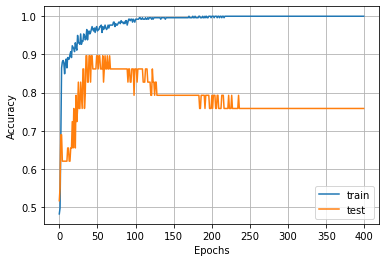

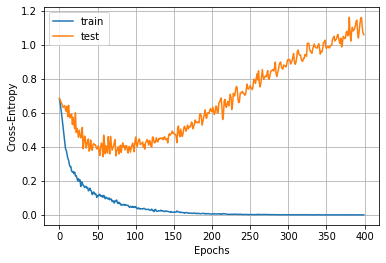


Iteration: 2
loss:  0.5380660891532898
accuracy:  0.8965517282485962
kappa:  0.7923627684964201
confusion matrix:
 [[12  2]
 [ 1 14]]
AUC 0.9761904761904763


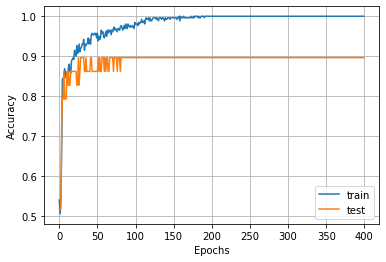

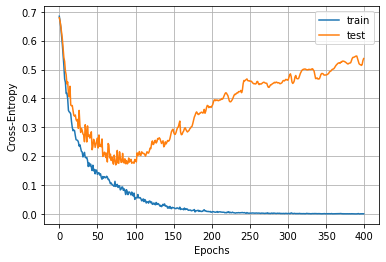


Iteration: 3
loss:  0.47278812527656555
accuracy:  0.931034505367279
kappa:  0.8625592417061612
confusion matrix:
 [[14  0]
 [ 2 13]]
AUC 0.9857142857142857


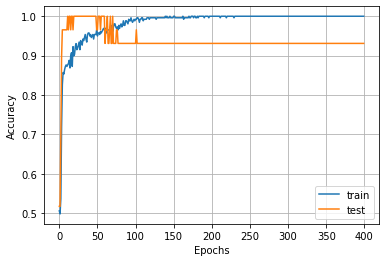

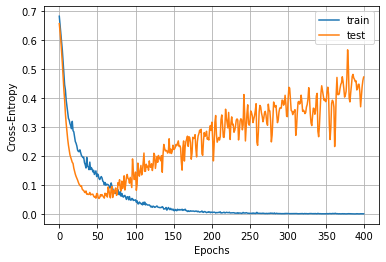


Iteration: 4
loss:  0.1502494364976883
accuracy:  0.9655172228813171
kappa:  0.9311163895486936
confusion matrix:
 [[14  0]
 [ 1 14]]
AUC 0.9857142857142857


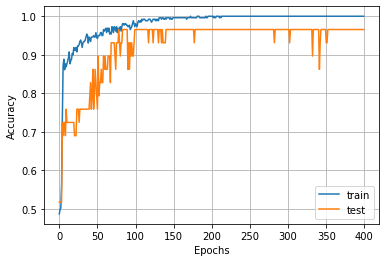

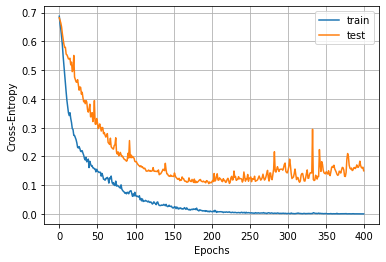


Iteration: 5
loss:  0.03006020560860634
accuracy:  0.9655172228813171
kappa:  0.9307875894988067
confusion matrix:
 [[15  0]
 [ 1 13]]
AUC 1.0


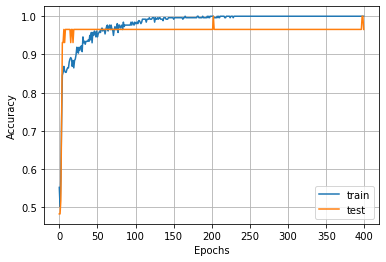

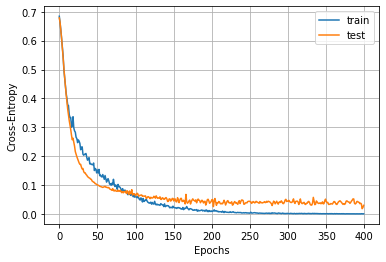


Iteration: 6
loss:  0.004525243304669857
accuracy:  1.0
kappa:  1.0
confusion matrix:
 [[15  0]
 [ 0 14]]
AUC 1.0


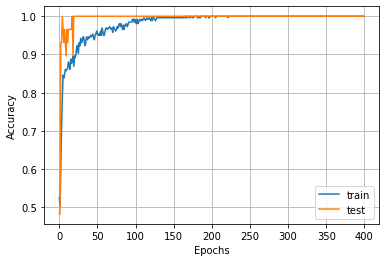

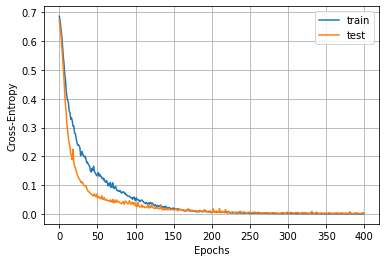


Iteration: 7
loss:  0.009063493460416794
accuracy:  1.0
kappa:  1.0
confusion matrix:
 [[15  0]
 [ 0 14]]
AUC 1.0


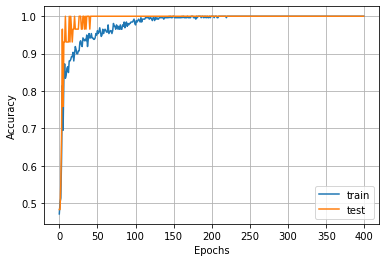

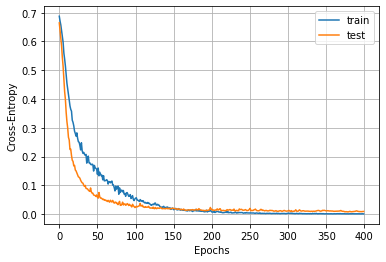


Iteration: 8
loss:  1.5807722806930542
accuracy:  0.8275862336158752
kappa:  0.6539379474940334
confusion matrix:
 [[13  2]
 [ 3 11]]
AUC 0.8476190476190476


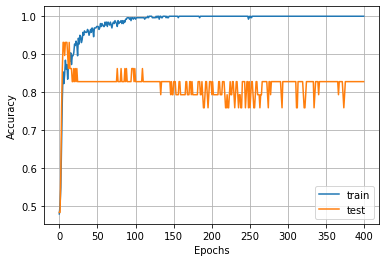

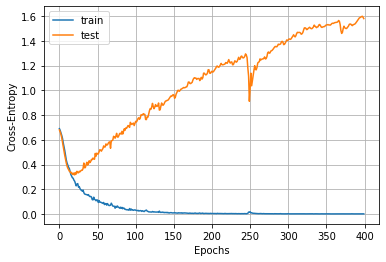


Iteration: 9
loss:  0.6125413179397583
accuracy:  0.8928571343421936
kappa:  0.7857142857142857
confusion matrix:
 [[13  1]
 [ 2 12]]
AUC 0.9591836734693877


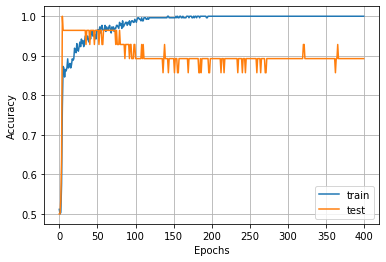

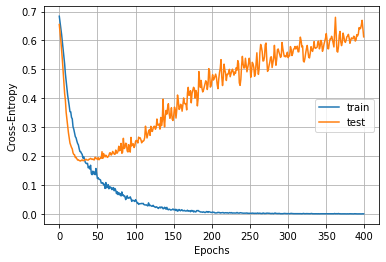


Iteration: 10
loss:  2.6501624584198
accuracy:  0.7857142686843872
kappa:  0.5714285714285714
confusion matrix:
 [[ 9  5]
 [ 1 13]]
AUC 0.8979591836734694


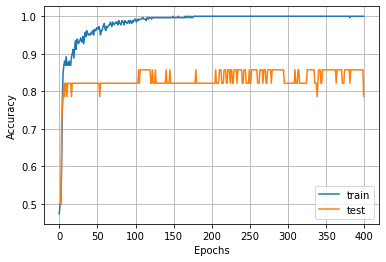

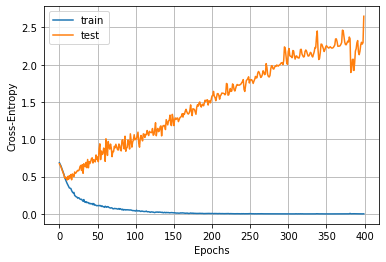


Resultados:
loss: [1.0599887371063232, 0.5380660891532898, 0.47278812527656555, 0.1502494364976883, 0.03006020560860634, 0.004525243304669857, 0.009063493460416794, 1.5807722806930542, 0.6125413179397583, 2.6501624584198]
accuracy: [0.7586206793785095, 0.8965517282485962, 0.931034505367279, 0.9655172228813171, 0.9655172228813171, 1.0, 1.0, 0.8275862336158752, 0.8928571343421936, 0.7857142686843872]
kappa: [0.520094562647754, 0.7923627684964201, 0.8625592417061612, 0.9311163895486936, 0.9307875894988067, 1.0, 1.0, 0.6539379474940334, 0.7857142857142857, 0.5714285714285714]
AUC: [0.919047619047619, 0.9761904761904763, 0.9857142857142857, 0.9857142857142857, 1.0, 1.0, 1.0, 0.8476190476190476, 0.9591836734693877, 0.8979591836734694]
Tiempo: 525.4219620227814


In [23]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]
  #y_train_categorical, y_test_categorical = y_categorical[iTrain], y_categorical[jTest]

  model = CNN_2D()
  
  '''history = model.fit_generator(datagen.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples/18),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0, callbacks=[mc])
  
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)'''

  history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  #fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
print("AUC:", array_auc)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [24]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 990, 31, 16)       160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 495, 15, 16)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 495, 15, 16)       2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 247, 7, 16)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 27664)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               3541120   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)             

In [25]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Mean AUC: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Max AUC: %.4f" % np.max(array_auc))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.9023
std: (+/- 0.0824)
Mean Kappa: 0.8048
std: (+/- 0.1644)
Mean AUC: 0.9571
std: (+/- 0.0495)
Max Accuracy: 1.0000
Max Kappa: 1.0000
Max AUC: 1.0000
Tiempo: 525


In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 17 23:04:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    45W /  70W |   1631MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------